# ResNet 34 - ResNet 50 FastAI models transfer learning on the Oxford-IIIT Pet Dataset

The idea is to do transfer learning from pretrained FastAI resnet models to a specific image recognition task. The original networks are trained on the ImageNet dataset, and the final layers are fine tuned to this new pet dataset.
- The ResNet 34 model achieves 94.3% accuracy with only 6 epochs of training.  
- The ResNet 50 model achieves 95% accuracy with only 10 epochs of training.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 64

## Data

[Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. There are 37 distinct categories.

In [4]:
path = untar_data(URLs.PETS); path
# Downloads and extracts the data from an URL

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet')

In [5]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images')]

In [6]:
path_anno = path/'annotations'
path_img = path/'images'

In [7]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Birman_61.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/saint_bernard_27.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/pomeranian_63.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/japanese_chin_198.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Sphynx_102.jpg')]

In [8]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [9]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)
# from_name_re method uses a RegEx pattern to create a DataBunch object containing trn, val and test datasets

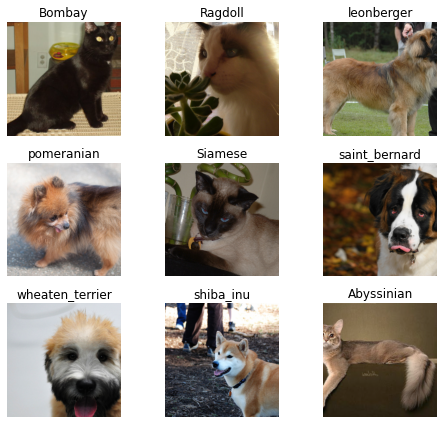

In [10]:
data.show_batch(rows=3, figsize=(7,6))

In [30]:
print(data.classes)
print(len(data.classes))
print(data.c)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
37
37


## Training: resnet34

This ResNet 34 uses a CNN backbone and a fully connected head with a single hidden layer as a classifier.

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [12]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [13]:
# fit_one_cycle fine tunes added layers at the end of the model!
# doesn't fit the entire model!
# Shouldn't overfit!

learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.389436,0.271559,0.098106,00:39
1,0.592520,0.240551,0.083897,00:22
2,0.386173,0.190970,0.062923,00:22
3,0.286592,0.193308,0.064276,00:22


In [14]:
learn.save('stage-1')

## Results

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

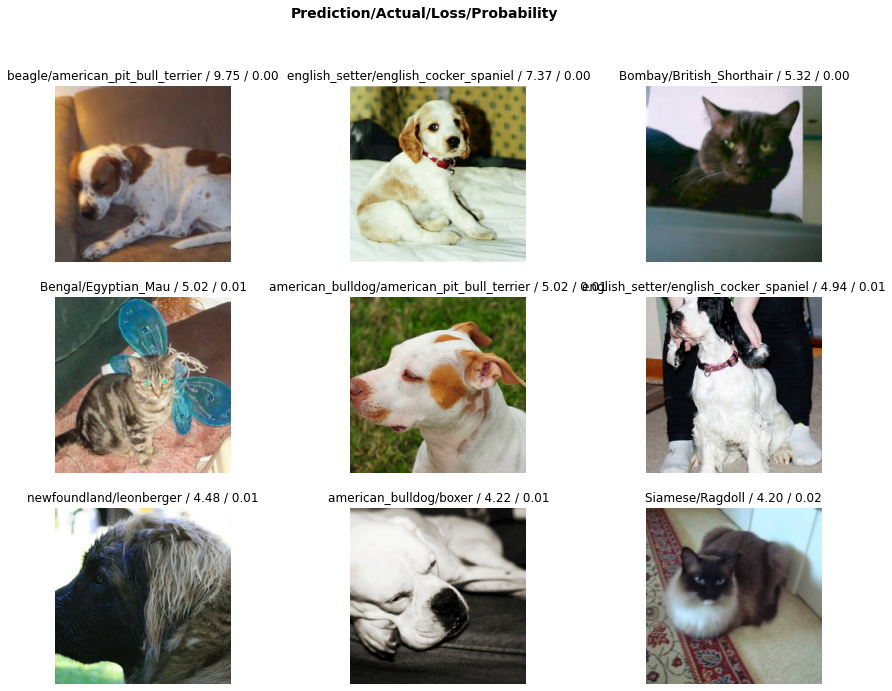

In [16]:
interp.plot_top_losses(9, figsize=(15,11))

In [17]:
doc(interp.plot_top_losses)

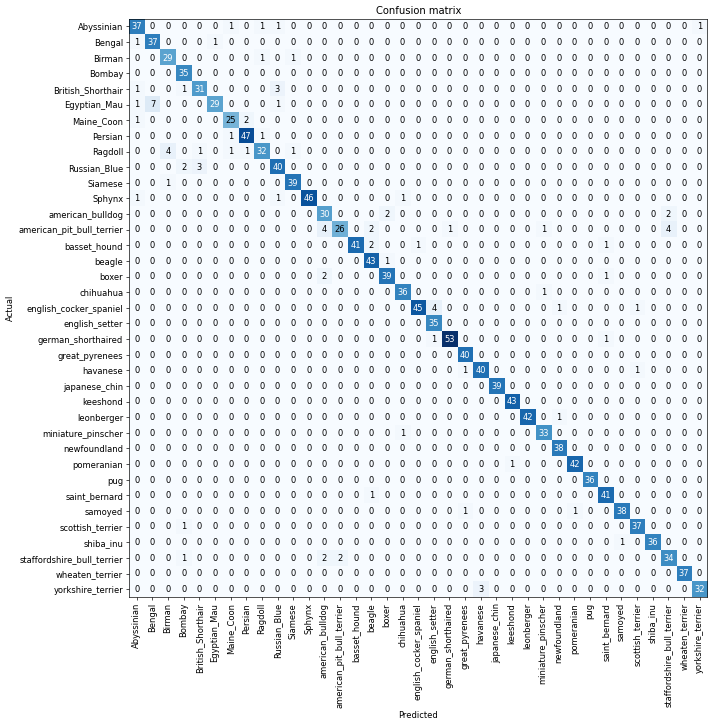

In [18]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [19]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 7),
 ('Ragdoll', 'Birman', 4),
 ('american_pit_bull_terrier', 'american_bulldog', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('english_cocker_spaniel', 'english_setter', 4),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('yorkshire_terrier', 'havanese', 3),
 ('Maine_Coon', 'Persian', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('american_bulldog', 'boxer', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('american_pit_bull_terrier', 'beagle', 2),
 ('basset_hound', 'beagle', 2),
 ('boxer', 'american_bulldog', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2)]

## Unfreezing, fine-tuning, and learning rates

In [20]:
# learn.unfreeze() allows to train entire model! not only last layers
learn.unfreeze()

In [21]:
learn.fit_one_cycle(1)
# training all layers doesn't help much => we would only like to fine tune the last layers.

epoch,train_loss,valid_loss,error_rate,time
0,0.718146,0.398316,0.119080,00:23


In [22]:
# Reload saved model
learn.load('stage-1');

In [23]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


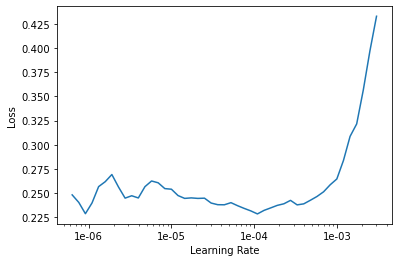

In [24]:
learn.recorder.plot()
# our initial lr was 0.003, so graph shows how loss gets worse if fine tuning with same lr

In [25]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))
# slice() will train first layers at 1e-5, last layers at 1e-4 and distribute rates in between layers

epoch,train_loss,valid_loss,error_rate,time
0,0.252340,0.183855,0.060893,00:23
1,0.202393,0.172759,0.056834,00:23


## Training: resnet50

If there are errors while training, reduce the batch size (this is caused by not enough GPU RAM).

In [26]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [27]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jupyter/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


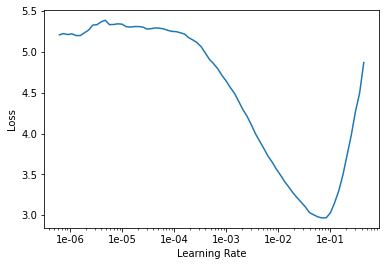

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.731994,0.322562,0.089986,00:49
1,0.528847,0.297430,0.087957,00:48
2,0.437899,0.298025,0.087280,00:48
3,0.332294,0.246067,0.071719,00:48
4,0.274420,0.229106,0.064276,00:48
5,0.214370,0.220046,0.061570,00:48
6,0.135200,0.199208,0.054804,00:48
7,0.097629,0.198553,0.062923,00:48


In [31]:
learn.save('stage-1-50')

## Fine Tuning the model

In [40]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.098101,0.185596,0.058187,01:03
1,0.094820,0.187078,0.056157,01:04
2,0.089186,0.175228,0.055480,01:04


In [39]:
#learn.load('stage-1-50');

In [49]:
learn.save('resnet50-10epochs')

In [55]:
learn.path/learn.model_dir

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/models')

In [56]:
%%bash
cd '/home/jupyter/.fastai/data/oxford-iiit-pet/images/models'
ls

resnet50-10epochs.pth
resnet50-10epochs.pth.pth
stage-1-50.pth
stage-1.pth
tmp.pth


In [59]:
interp = ClassificationInterpretation.from_learner(learn)

In [60]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 9),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('staffordshire_bull_terrier', 'american_bulldog', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('Birman', 'Ragdoll', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('chihuahua', 'shiba_inu', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('scottish_terrier', 'havanese', 2)]

Model is still making mistakes with breeds that are difficult to distinguish even for experts.